<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an flow model and run it on one to two datasets. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 36.21 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16677 sha256=9338ee07212db3ff942103367f2784d132d0092c1c5d9040d9fcb3d7697b8802
  Stored in directory: /tmp/pip-ephem-wheel-cache-uqt_r3je/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [2]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


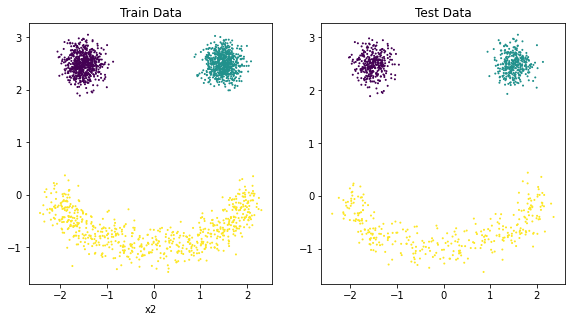

Dataset 2


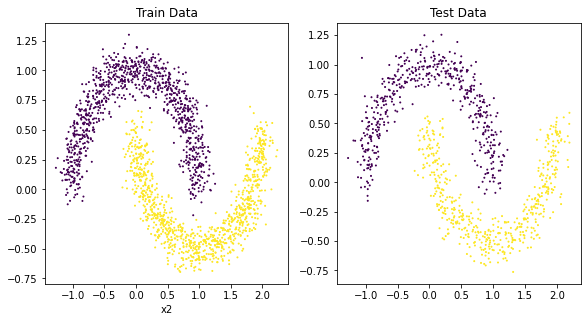

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow [15pt]

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d \log p(z_i) + \log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space. 




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

import deepul.pytorch_util as ptu

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
def train(model, train_loader, optimizer):
    model.train()
    losses = []
    for x in train_loader:
        x = x.to(device).float().contiguous()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device).float().contiguous()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)  # loss at init
    for epoch in range(epochs):
        model.train()
        epoch_train_losses = train(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)

        print(f"EPOCH {epoch}, test loss: {test_loss}")
            
    return train_losses, test_losses

In [139]:
class NP2D(data.Dataset):

    def __init__(self, x):
        self.x = x

    def __getitem__(self, ind):
        return self.x[ind]
    
    def __len__(self):
        return self.x.shape[0]  
    

def mixture_of_gaussian_cdf(mean, log_std, weight_logit, num, x):
    """
    x: B * 1
    mean, std, weight: 1 * num or B * num
    """
    dist = Normal(mean, log_std.exp())
    val = x.repeat(1, num)
    weight = F.softmax(weight_logit, dim=1)
    ret = (dist.cdf(val) * weight).sum(dim=1)
    return ret

def mixture_of_gaussian_logpdf(mean, log_std, weight_logit, num, x):
    """
    x: B * 1
    mean, std, weight: 1 * num or B * num

    """
    dist = Normal(mean, log_std.exp())
    val = x.repeat(1, num)
    weight = F.softmax(weight_logit, dim=1)
    return (dist.log_prob(val).exp() * weight).sum(dim=1).log()

class MixtureOfGaussianFlow(nn.Module):

    def __init__(self, num=5):
        super().__init__()
        self.num = num
        self.mean = nn.Parameter(torch.randn(self.num)) 
        self.log_std = nn.Parameter(torch.zeros(self.num)) 
        self.weight_logit = nn.Parameter(torch.zeros(self.num)) 
        _zero = torch.tensor([0.0]).to(device)
        _one = torch.tensor([1.0]).to(device)

        self.z_dist = Uniform(_zero, _one)
    
    def forward(self, x):
        return mixture_of_gaussian_cdf(self.mean.unsqueeze(0), self.log_std.unsqueeze(0), self.weight_logit.unsqueeze(0), self.num, x)

    def log_prob(self, x, z):
        # log pz(f(x)) + log(dz/dx).abs
        # dz/dx is just pdf_mixture_of_normal(x), which is positive

        return self.z_dist.log_prob(z) + mixture_of_gaussian_logpdf(self.mean.unsqueeze(0), self.log_std.unsqueeze(0), self.weight_logit.unsqueeze(0), self.num, x)

    def loss(self, log_prob):
        return - log_prob.mean()

class MLP(nn.Module):
    def __init__(self, out, hidden):
        super().__init__()
        self.out = out
        self.hidden = hidden

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(1, hidden[0]))
        for l in range(len(hidden) - 1):
            self.layers.append(nn.Linear(hidden[l], hidden[l + 1]))
        self.out_layer = nn.Linear(hidden[-1], out)

    def forward(self, x):
        
        for l in self.layers:
            x = F.relu(l(x))
        return self.out_layer(x)

class ARFlow2D(nn.Module):

    def __init__(self, num_1, num_2, hidden):
        super().__init__()
        self.num_1 = num_1
        self.flow_1 = MixtureOfGaussianFlow(num_1)

        self.num_2 = num_2
        self.dim_2_param_nn = MLP(3 * num_2, hidden)

        _zero = torch.tensor([0.0]).to(device)
        _one = torch.tensor([1.0]).to(device)

        self.z2_dist = Uniform(_zero, _one)

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, 1)
        z1 = self.flow_1(x1)
        param = self.dim_2_param_nn(x1)
        mean_2, log_std_2, weight_logit_2 = torch.chunk(param, 3, 1)
        z2 = mixture_of_gaussian_cdf(mean_2, log_std_2, weight_logit_2, self.num_2, x2)
        return torch.stack([z1, z2], dim=1)

    def log_prob(self, x):
        x1, x2 = torch.chunk(x, 2, 1)
        # loss from flow 1
        z1 = self.flow_1(x1)
        log_prob_1 = self.flow_1.log_prob(x1, z1)
        # loss from flow 2
        param = self.dim_2_param_nn(x1)
        mean_2, log_std_2, weight_logit_2 = torch.chunk(param, 3, 1)
        z2 = mixture_of_gaussian_cdf(mean_2, log_std_2, weight_logit_2, self.num_2, x2)
        log_prob_2 = self.z2_dist.log_prob(z2) + mixture_of_gaussian_logpdf(mean_2, log_std_2, weight_logit_2, self.num_2, x2)

        return log_prob_1 + log_prob_2

    def loss(self, x):
        x1, x2 = torch.chunk(x, 2, 1)
        # loss from flow 1
        z1 = self.flow_1(x1)
        log_prob_1 = self.flow_1.log_prob(x1, z1)
        loss_1 = self.flow_1.loss(log_prob_1)
        # loss from flow 2
        param = self.dim_2_param_nn(x1)
        mean_2, log_std_2, weight_logit_2 = torch.chunk(param, 3, 1)
        z2 = mixture_of_gaussian_cdf(mean_2, log_std_2, weight_logit_2, self.num_2, x2)
        log_prob_2 = self.z2_dist.log_prob(z2) + mixture_of_gaussian_logpdf(mean_2, log_std_2, weight_logit_2, self.num_2, x2)
        loss_2 =  - log_prob_2.mean()
        return loss_1 + loss_2



In [142]:
def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats in R^2
    test_data: An (n_test, 2) numpy array of floats in R^2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets, or
              for plotting a different region of densities

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
        Refer to the commented hint.
    - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
        mapping the train set data points through our flow to the latent space. 
    """
    
    """ YOUR CODE HERE """
    # create data loaders
    train_ds = NP2D(train_data)
    test_ds = NP2D(test_data)
    loader_args = dict(batch_size=128, shuffle=True)
    train_loader = data.DataLoader(dataset=train_ds, **loader_args)
    test_loader = data.DataLoader(dataset=test_ds, **loader_args)
    # model
    model = ARFlow2D(5, 5, [32, 64, 32])
    model.to(device)
    # train
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, dict(epochs=200, lr=1e-3))
    # heatmap
    dx, dy = 0.025, 0.025
    if dset_id == 1:  # face
        x_lim = (-4, 4)
        y_lim = (-4, 4)
    elif dset_id == 2:  # two moons
        x_lim = (-1.5, 2.5)
        y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = ptu.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(device)
    densities = np.exp(ptu.get_numpy(model.log_prob(mesh_xs)))

    print(densities.shape)

    # latents
    with torch.no_grad():
      latents = model(torch.FloatTensor(train_data).to(device)).cpu().numpy()

    return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



EPOCH 0, test loss: 4.14408540725708
EPOCH 1, test loss: 3.7865283489227295
EPOCH 2, test loss: 3.6595683097839355
EPOCH 3, test loss: 3.545593023300171
EPOCH 4, test loss: 3.450162172317505
EPOCH 5, test loss: 3.1934354305267334
EPOCH 6, test loss: 2.756004810333252
EPOCH 7, test loss: 2.542419195175171
EPOCH 8, test loss: 2.3343594074249268
EPOCH 9, test loss: 2.2488486766815186
EPOCH 10, test loss: 2.141042470932007
EPOCH 11, test loss: 2.0970704555511475
EPOCH 12, test loss: 2.0561444759368896
EPOCH 13, test loss: 2.054246664047241
EPOCH 14, test loss: 2.009481906890869
EPOCH 15, test loss: 1.9946627616882324
EPOCH 16, test loss: 1.9696468114852905
EPOCH 17, test loss: 1.9492301940917969
EPOCH 18, test loss: 1.9298443794250488
EPOCH 19, test loss: 1.9620237350463867
EPOCH 20, test loss: 1.8978033065795898
EPOCH 21, test loss: 1.8815523386001587
EPOCH 22, test loss: 1.8787740468978882
EPOCH 23, test loss: 1.866682529449463
EPOCH 24, test loss: 1.8453712463378906
EPOCH 25, test loss:

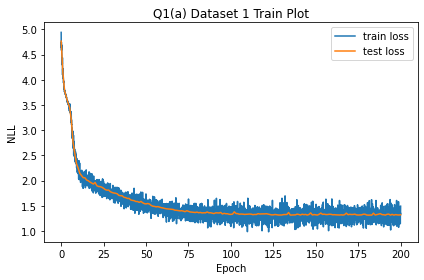

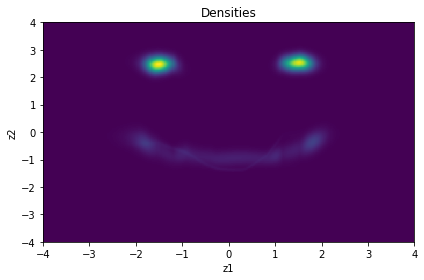

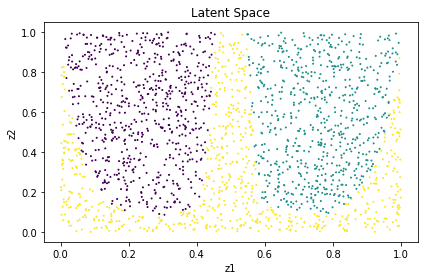

In [143]:
q1_save_results(1, 'a', q1_a)

EPOCH 0, test loss: 2.2261343002319336
EPOCH 1, test loss: 1.9988831281661987
EPOCH 2, test loss: 1.8839174509048462
EPOCH 3, test loss: 1.8445868492126465
EPOCH 4, test loss: 1.8132315874099731
EPOCH 5, test loss: 1.7738192081451416
EPOCH 6, test loss: 1.7345250844955444
EPOCH 7, test loss: 1.6480052471160889
EPOCH 8, test loss: 1.5953747034072876
EPOCH 9, test loss: 1.5591801404953003
EPOCH 10, test loss: 1.5351028442382812
EPOCH 11, test loss: 1.5044407844543457
EPOCH 12, test loss: 1.4819358587265015
EPOCH 13, test loss: 1.4701472520828247
EPOCH 14, test loss: 1.4769165515899658
EPOCH 15, test loss: 1.4228874444961548
EPOCH 16, test loss: 1.4194484949111938
EPOCH 17, test loss: 1.4223300218582153
EPOCH 18, test loss: 1.4532893896102905
EPOCH 19, test loss: 1.418676495552063
EPOCH 20, test loss: 1.3999372720718384
EPOCH 21, test loss: 1.3790496587753296
EPOCH 22, test loss: 1.3638652563095093
EPOCH 23, test loss: 1.3632032871246338
EPOCH 24, test loss: 1.3701766729354858
EPOCH 25, t

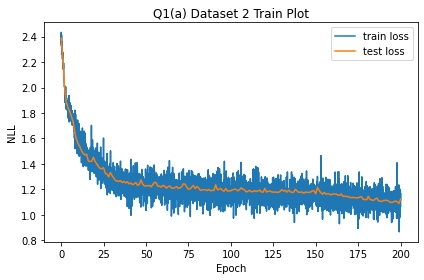

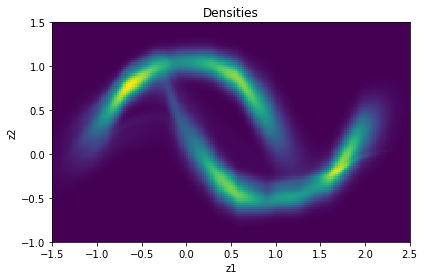

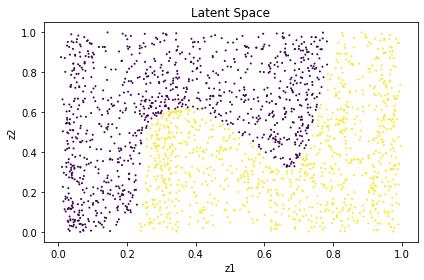

In [144]:
q1_save_results(2, 'a', q1_a)